In [459]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import pickle as pkl
sys.path.append('/home/jungyoung/Project/hh_neuralnet/include/')
import hhtools
import hhsignal
import importlib
from tqdm.notebook import tqdm
# other options
plt.rcParams['figure.dpi'] = 120
plt.rcParams['figure.facecolor'] = 'w'
np.set_printoptions(suppress=True)

from scipy import signal

In [437]:
# def filt_between(sig, f1, f2, fs=2000, fo=10):
#     sos1 = signal.butter(fo, f1, 'hp', fs=fs, output='sos')
#     filtered = signal.sosfilt(sos1, sig)
    
#     sos2 = signal.butter(fo, f2, 'lp', fs=fs, output='sos')
#     filtered = signal.sosfilt(sos2, filtered)
    
#     return filtered

def filt_between(sig, f1, f2, fs=2000, fo=10):
    b1, a1 = signal.butter(fo, f1, 'hp', fs=fs, output='ba')
    filtered = signal.filtfilt(b1, a1, sig, padlen=50)
    
    b2, a2 = signal.butter(fo, f2, 'lp', fs=fs, output='ba')
    filtered = signal.filtfilt(b2, a2, filtered, padlen=50)
    
    return filtered

# Verify the bandpass filtering in python

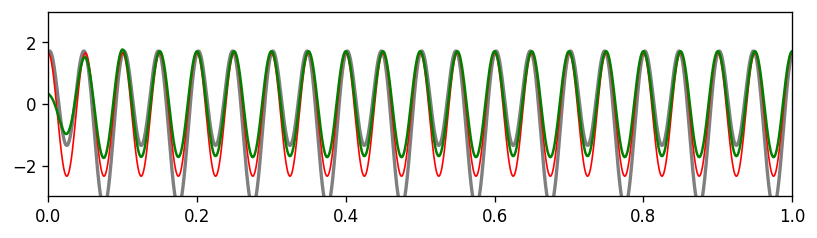

In [3]:
srate = 2000
t = np.arange(0, 3, 1/srate)

np.random.rand(100)

phs_true = (2*np.pi*20*t + np.pi) % (2*np.pi) - np.pi

sig1 = np.sin(2*np.pi*10*t)
sig2 = 2*np.cos(phs_true) + np.random.randn()

sig = sig1 + sig2
filtered = filt_between(sig, 15, 25, fo=5, fs=srate)

plt.figure(figsize=(8, 2))
plt.plot(t, sig, 'k', lw=2, alpha=0.5)
plt.plot(t, sig2, 'r', lw=1)
plt.plot(t, filtered, c='g')
plt.ylim([-3, 3])
plt.xlim([0, 1.])
plt.show()

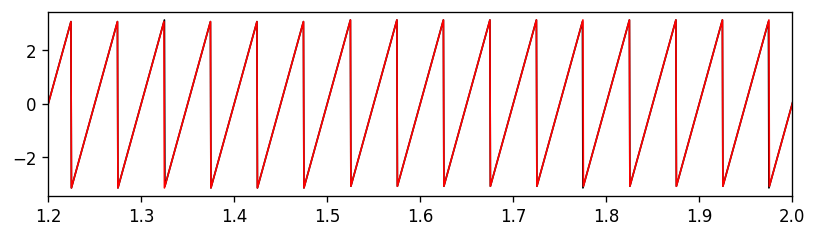

In [4]:
# phs_true = np.angle(signal.hilbert(sig2))
phs_filt = np.angle(signal.hilbert(filtered)) # sig2 = np.cos(.)

plt.figure(figsize=(8, 2))
plt.plot(t, phs_true, 'k', lw=1)
plt.plot(t, phs_filt, 'r', lw=1)
plt.xlim([1.2, 2])
plt.show()

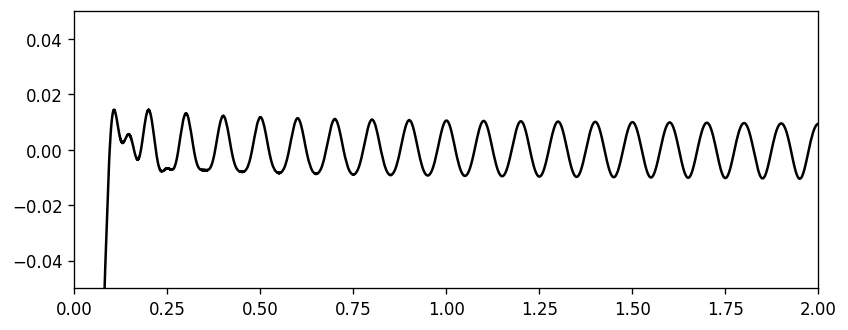

In [5]:
# dp = (2*np.pi*22*t - np.unwrap(phs_filt)) % 
dp = np.unwrap(phs_true - phs_filt)

plt.figure(figsize=(8, 3))
plt.plot(t, dp, c='k')
plt.ylim([-0.05, 0.05])
plt.xlim([0, 2])
plt.show()

# Cell activity response

In [469]:
sobj = hhtools.SummaryLoader("./data/")

# fpeaks are computed in validate_result.ipynb
fpeaks = (([39.520], [34.517], [31.016], [60.030], [34.517, 61.531], [61.031], [66.533], [68.534]), # Fast subpop
          ([25.513], [25.513], [27.014], [35.018], [34.017, 65.033], [29.515], [66.533, 22.011], [34.017, 68.034])) # Slow subpop


Load cache file


## Show power spectrogram

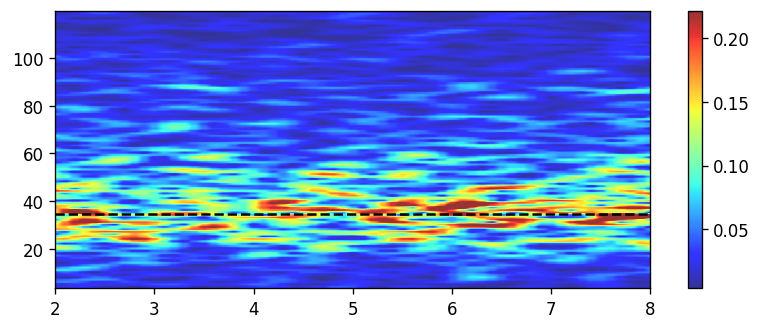

In [461]:
cid = 2
nt = 100
xl = [2, 8]

nc = cid - 1
detail = sobj.load_detail(nc, nt)
v_fast = detail["vlfp"][1]

psd, fpsd, tpsd = hhsignal.get_stfft(v_fast, detail["ts"], fs=2000, mbin_t=0.1, wbin_t=1, frange=(4, 120))

plt.figure(figsize=(8, 3))
hhtools.imshow_xy(psd, x=tpsd, y=fpsd, cmap="jet", alpha=0.8)
for fp in fpeaks[0][nc]:
    plt.hlines(fp, xl[0], xl[1], color='k', linestyles='--')
plt.xlim(xl)
plt.colorbar()
plt.show()

In [529]:
cid = 1
tmax = 10.5
teq = 0.5
wbin_t = 0.5

nsample = 100

np.random.seed(100)

amp_set = [[], []]
fhalf = 5

for nt in range(20):
    detail = sobj.load_detail(cid-1, nt)
    
    for _ in range(nsample):
        t0 = np.random.rand() * (tmax - teq - wbin_t) + teq
        detail = sobj.load_detail(cid-1, nt)
        v_sub = detail["vlfp"][1][int(t0*srate):int((t0+wbin_t)*srate)]

        yf, f = hhsignal.get_fft(v_sub, srate, frange=frange)

        for n in range(len(fpeaks[0][cid-1])):
            idf = (f >= fpeaks[0][cid-1][n] - fhalf) & (f < fpeaks[0][cid-1][n] + fhalf)
            amp_set[n].append(np.average(yf[idf]))

(0.0, 1.5)

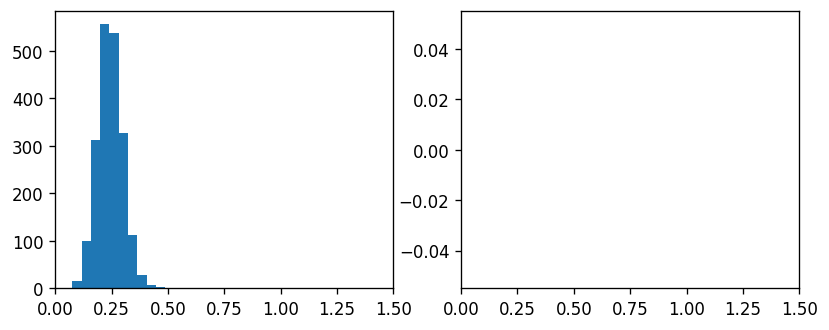

In [530]:
plt.figure(figsize=(8, 3))
plt.subplot(121)
plt.hist(amp_set[0])
plt.xlim([0, 1.5])

plt.subplot(122)
plt.hist(amp_set[1])
plt.xlim([0, 1.5])

In [573]:
@jit(nopython=True)
def get_favg(yf, f, fpeaks):
    yf_avg = np.zeros(len(fpeaks))
    for nf in range(len(fpeaks)):
        # frange = fpeaks[nf]
        for i in range(len(f)):
            f0 = f[i]
            if (f0 >= fpeaks[nf]-5) and (f0 < fpeaks[nf]+5):
                yf_avg[nf] += yf[i]
                
    return yf_avg

In [570]:
fp = np.array([fpeaks[0][1]])
amp = get_favg(yf, f, fp)

In [572]:
%%timeit
amp = get_favg(yf, f, fp)

2.45 µs ± 23.2 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [574]:
%%timeit
amp = get_favg(yf, f, fp)

143 µs ± 3.28 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [664]:
with open("./joint_corr_amp.pkl", "rb") as fp:
    data = pkl.load(fp)

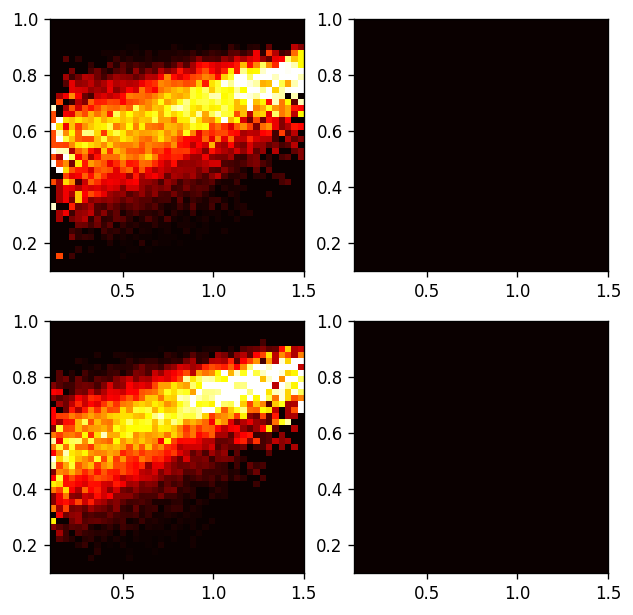

In [696]:
def cond_prob(joint, pth=1e-5):
    p_margin = get_margin(joint)
    cond = np.zeros_like(joint)
    for n in range(joint.shape[1]):
        if p_margin[n] < pth:
            continue
        
        cond[:, n] = joint[:, n] / p_margin[n]
    return cond

cid = 2
c = get_edge_half(data["amp_edges"])
r = get_edge_half(data["cc_edges"])

plt.figure(figsize=(6, 6))
for i in range(2):
    for j in range(2):
        plt.subplot(2,2,2*i+j+1)
        cond = cond_prob(data["corr"][cid-1][i][j])
        hhtools.imshow_xy(cond, cmap="hot", vmin=0, vmax=0.05, x=c, y=r)
        
        # joint = data["corr"][cid-1][i][j]
        # hhtools.imshow_xy(joint, cmap="hot", vmin=0, vmax=None, x=c, y=r)
        
        # plt.xlabel("
        
plt.show()

In [ ]:
def cond_prob(joint, pth=1e-5):
    p_margin = get_margin(joint)
    cond = np.zeros_like(joint)
    for n in range(joint.shape[1]):
        if p_margin[n] < pth:
            continue
        
        cond[:, n] = joint[:, n] / p_margin[n]
    return cond

pop_names = ["F", "S"]

# cid = 2
for cid in range(1, 9):
    c = get_edge_half(data["amp_edges"])
    r = get_edge_half(data["cc_edges"])

    plt.figure(figsize=(7, 6))
    for nt in range(2):
        for i in range(2):
            plt.subplot(2,2,2*nt+i+1)
            cond = cond_prob(data["corr"][cid-1][nt][i])
            vm = np.percentile(cond, 95)
            hhtools.imshow_xy(cond, cmap="hot", vmin=0, vmax=vm, x=c, y=r)
            plt.colorbar(shrink=0.5)

            try:
                f0 = np.round(fpeaks[nt][cid-1][i], 0)
                plt.xlabel(r"$A_{[%d,%d] Hz}$(%s)"%(f0-5, f0+5, pop_names[nt]), fontsize=14)
            except:
                continue
            plt.xticks([0.1, 0.5, 1, 1.5])
            plt.ylabel(r"$\chi_P^*$", fontsize=14)

    plt.suptitle("cid %d"%(cid), fontsize=15)
    plt.tight_layout()        
    plt.show()

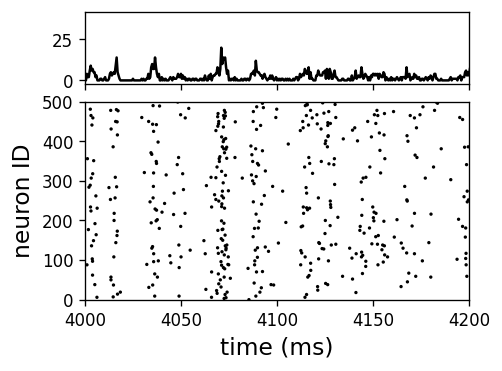

In [775]:
detail = sobj.load_detail(4, 10)
pop_rate, t = get_pop_rate(detail["step_spk"])

plt.figure(figsize=(4, 3))
plt.axes(position=[0.1, 0.7, 0.8, 0.2])
plt.plot(t, pop_rate[0], c='k')
plt.xlim([4, 4.2])
plt.xticks(np.arange(4, 4.21, 0.05), labels=[])
# plt.ylabel("# neurons per time", fontsize=14)

plt.axes(position=[0.1, 0.1, 0.8, 0.55])
hhtools.draw_spk(detail["step_spk"][:500], colors="k", xl=(4000, 4200))
plt.ylabel("neuron ID", fontsize=14)
plt.xlabel("time (ms)", fontsize=14)

plt.show()

In [799]:
@jit(nopython=True)
def get_yf_avg(yf, f, fpeaks):
    yf_avg = np.zeros(len(fpeaks))
    for nf in range(len(fpeaks)):
        # frange = fpeaks[nf]
        for i in range(len(f)):
            f0 = f[i]
            # print(fpeaks[nf], f0)
            if (f0 >= fpeaks[nf]-5) and (f0 < fpeaks[nf]+5):
                yf_avg[nf] += yf[i]
                
    return yf_avg

In [804]:
with open("./joint_corr_amp.pkl", "rb") as fp:
    data = pkl.load(fp)

In [805]:
data.keys()

dict_keys(['corr', 'cc_edges', 'amp_edges', 'fpeaks'])

In [806]:
data["corr"]

AttributeError: 'list' object has no attribute 'shape'

In [807]:
corr = data["corr"][0]

In [808]:
corr.shape

(2, 2, 41, 40)

In [840]:
def get_threshold(x, xprob, percent):
    cum = np.cumsum(xprob)*100
    # find nn points
    if np.any(cum == percent):
        return x[np.where(cum == percent)[0][0]]
    
    nr = np.where(cum > percent)[0][0]
    nl = np.where(cum < percent)[0][-1]
    
    pr = cum[nr]
    pl = cum[nl]
    ratio = np.array([pr - percent, percent - pl])
    ratio = ratio / np.sum(ratio)
    
    return x[nr]*ratio[1] + x[nl]*ratio[0]



    

In [842]:
data.keys()

dict_keys(['corr', 'cc_edges', 'amp_edges', 'fpeaks'])

In [851]:
tmax = 10.5
teq  = 0.5
wbin_t = 0.5
srate = 2000
frange = (2/wbin_t, 100)

xa = get_edge_half(data["amp_edges"])

cid = 1

np.random.seed(200)

num_e = 41
fr_edges = np.linspace(-np.pi, np.pi, num_e)
hist_firng = np.zeros([11, num_e]) # 

ath_set = []
# aoff_set = []
for nt in range(2):
    ath_set.append([])
    for nf in range(2):
        p_margin = get_margin(data["corr"][cid-1][nt][nf])
        if np.all(p_margin == 0):
            ath_set[nt].append([])
            # aoff_set[nt].append([])
        else:
            ath_set[nt].append(get_threshold(xa, p_margin, 95))
            # aoff_set[nt].append(get_threshold(xa, p_margin, 5))

for nitr in range(5):
    detail = sobj.load_detail(cid-1, nitr)
    
    for nt in range(2):
        
        yf = filt_between(detail["vlfp"][nt], , frange[1], fs=srate, fo=fo)
    
    
    for n in range(10):
        t0 = np.random.rand() * (tmax - teq - wbin_t) + teq
        n0 = int(t0 * srate)
        n1 = n0 + int(wbin_t * srate)
        
        on_state = [False, False, False, False]
        
        v1 = detail["vlfp"][1][n0:n1]
        yf1, f = hhsignal.get_fft(v1, srate, frange=frange)
        amp_peaks1 = get_yf_avg(yf1, f, np.array(fpeaks[0][cid-1]))
        for i in range(len(amp_peaks1)):
            on_state[i] = amp_peaks1[i] >= ath_set[0][i]
        
        v2 = detail["vlfp"][2][n0:n1]
        yf2, f = hhsignal.get_fft(v1, srate, frange=frange)
        amp_peaks2 = get_yf_avg(yf2, f, np.array(fpeaks[1][cid-1]))
        for i in range(len(amp_peaks2)):
            on_state[i+2] = amp_peaks2[i] >= ath_set[1][i]
        
        for i in range(4):
            if on_state[i]:
                pass
        
        
        

In [853]:
on_state

[True, False, False, False]

In [848]:
amp_peaks1

array([1.18550239])

In [846]:
ath_set

[[1.2040000000000006, []], [1.3222676579925652, []]]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0.])

In [803]:
amp_peaks2


array([0.87061878])

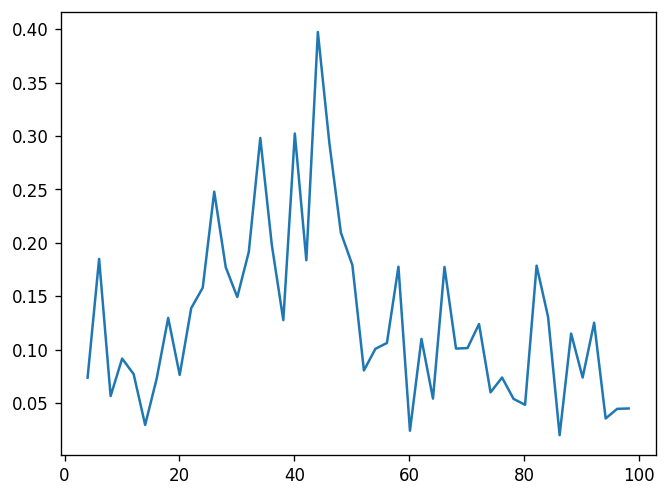

In [798]:
plt.plot(f, yf1)

# Phase histogram (run 'compute_spike_phase_hist.py')

In [438]:
def get_hist_boundary(phs_bins, edges):
    x, y = [edges[0]], [0]
    for n in range(len(phs_bins)):
        x.extend([edges[n], edges[n+1]])
        y.extend([phs_bins[n], phs_bins[n]])
    x.append(edges[-1])
    y.append(0)
    return x, y


def draw_vline():
    yl = plt.ylim()
    xl = plt.xlim()
    
    for x in (-np.pi, -np.pi/2, 0, np.pi/2, np.pi):
        plt.vlines(x, yl[0], yl[1], color='k', linestyles='--', lw=1)
        
    plt.ylim(yl)
    plt.xlim(xl)


with open("./spike_phs_hist.pkl", "rb") as fp:
    phs_hist_data = pkl.load(fp)
    
phs_hist_data["edges"] = np.linspace(-np.pi, np.pi, 51)

In [ ]:
lb_pop = ["F", "S"]
lb_types = [r"$E_F$", r"$I_F$", r"$E_S$", r"$I_S$"]
lopt = [
    dict(lw=1.2, alpha=1, c="r"),
    dict(lw=1.2, alpha=0.5, c="k")
]

cid = 1

phs_set = phs_hist_data["phs_bin_set"][cid-1]
fp_info = phs_hist_data["fp_cid_set"][cid-1]
edges = phs_hist_data["edges"]

num_fp = phs_set.shape[1]

plt.figure(figsize=(2*num_fp, 6))

for nfp in range(num_fp):
    ntype = fp_info[nfp]["ntype"]
    frange = fp_info[nfp]["frange"]
    
    for popid in range(4):
        plt.subplot(4, num_fp, popid*num_fp + nfp+1)
        for ma in range(2): # thresholding
            x, y = get_hist_boundary(phs_set[ma][nfp][popid]/200, edges)
            plt.plot(x, y, **lopt[ma])
            
        plt.xticks((-np.pi, 0, np.pi), (r"$-\pi$", "0", r"$\pi$"))
            
        if nfp == 0:
            plt.ylabel(lb_types[popid])
            
        if popid == 3:
            plt.xlabel(r"$\phi_{[%d,%d] Hz} (V_%s)$"%(frange[0], frange[1], lb_pop[ntype]))
        
        plt.yticks(fontsize=8, rotation=60)
        draw_vline()

plt.suptitle("Cluster %d"%(cid), fontsize=16)
plt.tight_layout()
plt.show()

In [449]:
import compute_spike_phase_hist as csph

sobj = hhtools.SummaryLoader("./data")

Load cache file


In [450]:
cid, nitr = 7, 100
# nfp = 1
# popid = 0

phs_edges = np.linspace(-np.pi, np.pi, 51)

fp_info = csph.scan_fpeaks(cid)
detail = sobj.load_detail(cid-1, nitr)
phs_set, amp_set = csph.compute_pa_at_spike(detail, fp_info)


phs_bins = csph.compute_histogram(phs_set, amp_set, phs_edges)


In [451]:
from tqdm.notebook import trange

lb_pop = ["F", "S"]
lb_types = [r"$E_F$", r"$I_F$", r"$E_S$", r"$I_S$"]
lopt = [
    dict(lw=1.2, alpha=1, c="r"),
    dict(lw=1.2, alpha=0.5, c="k")
]

num_cells = [800, 200, 800, 200]
phs_edges = np.linspace(-np.pi, np.pi, 51)

# cid = 7
for cid in trange(1, 9):

    for nitr in [10, 20, 50, 100, 150, 180]:

        fp_info = csph.scan_fpeaks(cid)
        detail = sobj.load_detail(cid-1, nitr)
        phs_set, amp_set = csph.compute_pa_at_spike(detail, fp_info)


        phs_bins = csph.compute_histogram(phs_set, amp_set, phs_edges)


        fp_info = phs_hist_data["fp_cid_set"][cid-1]
        edges = phs_hist_data["edges"]
        num_fp = phs_bins.shape[1]

        plt.figure(figsize=(2*num_fp, 6))

        for nfp in range(num_fp):
            ntype = fp_info[nfp]["ntype"]
            frange = fp_info[nfp]["frange"]
            
            for popid in range(4):
                plt.subplot(4, num_fp, popid*num_fp + nfp+1)
                for ma in range(2): # thresholding
                    x, y = get_hist_boundary(phs_bins[ma][nfp][popid]/num_cells[popid], edges)
                    plt.plot(x, y, **lopt[ma])
                    
                plt.xticks((-np.pi, 0, np.pi), (r"$-\pi$", "0", r"$\pi$"))
                    
                if nfp == 0:
                    plt.ylabel(lb_types[popid])
                    
                if popid == 3:
                    plt.xlabel(r"$\phi_{[%d,%d] Hz} (V_%s)$"%(frange[0], frange[1], lb_pop[ntype]))
                
                plt.yticks(fontsize=8, rotation=60)
                draw_vline()

        plt.suptitle("Cluster %d (%d)"%(cid, nitr), fontsize=16)
        plt.tight_layout()
        
        plt.savefig("./samplefigs/cid%d_%d.png"%(cid, nitr))
        plt.clf()
        
print("Done")

  0%|          | 0/8 [00:00<?, ?it/s]

/tmp/ipykernel_1171335/21680137.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(2*num_fp, 6))


Done


<Figure size 480x720 with 0 Axes>

<Figure size 480x720 with 0 Axes>

<Figure size 480x720 with 0 Axes>

<Figure size 480x720 with 0 Axes>

<Figure size 480x720 with 0 Axes>

<Figure size 480x720 with 0 Axes>

<Figure size 480x720 with 0 Axes>

<Figure size 480x720 with 0 Axes>

<Figure size 480x720 with 0 Axes>

<Figure size 480x720 with 0 Axes>

<Figure size 480x720 with 0 Axes>

<Figure size 480x720 with 0 Axes>

<Figure size 480x720 with 0 Axes>

<Figure size 480x720 with 0 Axes>

<Figure size 480x720 with 0 Axes>

<Figure size 480x720 with 0 Axes>

<Figure size 480x720 with 0 Axes>

<Figure size 480x720 with 0 Axes>

<Figure size 480x720 with 0 Axes>

<Figure size 480x720 with 0 Axes>

<Figure size 480x720 with 0 Axes>

<Figure size 480x720 with 0 Axes>

<Figure size 480x720 with 0 Axes>

<Figure size 480x720 with 0 Axes>

<Figure size 960x720 with 0 Axes>

<Figure size 960x720 with 0 Axes>

<Figure size 960x720 with 0 Axes>

<Figure size 960x720 with 0 Axes>

<Figure size 960x720 with 0 Axes>

<Figure size 960x720 with 0 Axes>

<Figure size 480x720 with 0 Axes>

<Figure size 480x720 with 0 Axes>

<Figure size 480x720 with 0 Axes>

<Figure size 480x720 with 0 Axes>

<Figure size 480x720 with 0 Axes>

<Figure size 480x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

# Population rate - CC

In [6]:
# Global parameters

tmax = 10.5
teq = 0.5
wbin_t = 0.2
srate = 2000


sobj = hhtools.SummaryLoader("./data")

Load cache file


In [642]:
from tqdm import trange
from scipy.signal import savgol_filter

def get_pop_rate(step_spk, fs=2000, tmax=10.5, dt=1e-5):
    l = int(tmax * fs)
    pop_rate = np.zeros([2, l])
    for n, _nt in enumerate(step_spk):
        nt = (np.array(_nt) * dt * fs).astype(int)
        pop_rate[n//1000][nt] += 1
    return pop_rate / len(step_spk) * fs, np.arange(l)/fs


def get_edge_half(edges):
    return (edges[1:] + edges[:-1])/2


def get_margin(joint):
    if np.sum(joint) == 0:
        return np.zeros(joint.shape[1])
    return np.sum(joint, axis=0) / np.sum(joint)


def cond_prob(joint, pth=1e-5):
    p_margin = get_margin(joint)
    cond = np.zeros_like(joint)
    for n in range(joint.shape[1]):
        if p_margin[n] < pth:
            continue
        
        cond[:, n] = joint[:, n] / p_margin[n]
    return cond


def out_range(x, xrange):
    return x < xrange[0] or x >= xrange[1]


def draw_prob_map(prob, x, y, **kwargs):
    hhtools.imshow_xy(prob, x=x, y=y, cmap="hot", **kwargs)
    # plt.axis("square")

In [536]:

@jit(nopython=True)
def get_pop_rate(step_spk, fs=2000, tmax=10.5, dt=1e-5):
    l = int(tmax * fs)
    pop_rate = np.zeros([2, l])
    for n, _nt in enumerate(step_spk):
        nt = (np.array(_nt) * dt * fs).astype(int)
        pop_rate[n//1000][nt] += 1
    return pop_rate / len(step_spk) * fs, np.arange(l)/fs

## CCrate - CClfp

In [135]:
# Population rate - Cross-correlation

cid = 2
nsample = 100

num_x, num_y = 42, 41

np.random.seed(2000)

cc_edges = np.linspace(0, 1, num_x)
cc_pop_edges = np.linspace(0, 1, num_y)
dx = cc_edges[1] - cc_edges[0]
dy = cc_pop_edges[1] - cc_pop_edges[0]
wbin = int(wbin_t * srate)

joint = np.zeros([num_y-1, num_x-1])
for ni in trange(200):
    detail = sobj.load_detail(cid-1, ni)

    pop_rate, t = get_pop_rate(detail["step_spk"])
    pop_rate = savgol_filter(pop_rate, 11, 1)
    vlfp = detail["vlfp"][1:]
    
    for n in range(nsample):
        n0 = int(np.random.rand() * (tmax - teq - wbin_t) * srate)
        
        cc_v, t = hhsignal.get_correlation(vlfp[0][n0:n0+wbin], vlfp[1][n0:n0+wbin], srate=srate, max_lag=0.1)
        cc_t, t = hhsignal.get_correlation(pop_rate[0][n0:n0+wbin], pop_rate[1][n0:n0+wbin], srate=srate, max_lag=0.1)
        
        cc_max = np.max(cc_v)
        cc_pop_max = np.max(cc_t)
        
        nx = int(cc_max / dx)
        ny = int(cc_pop_max / dy)
        
        if out_range(nx, [0, num_x]) or out_range(ny, [0, num_y]):
            continue
        
        joint[ny, nx] += 1

joint /= np.sum(joint)

100%|█████████████████████████████████████████████████████████████████████| 200/200 [00:07<00:00, 26.18it/s]


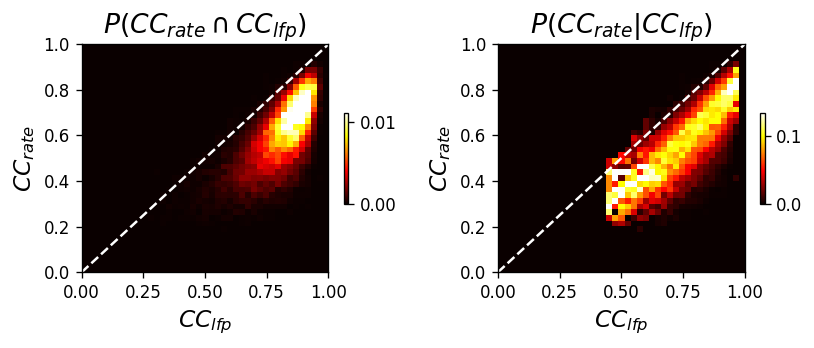

In [136]:
x = get_edge_half(cc_edges)
y = get_edge_half(cc_pop_edges)
cond = cond_prob(joint, pth=1e-3)

plt.figure(figsize=(7, 3))

plt.subplot(121)
draw_prob_map(joint, x, y)
plt.plot([0, 1], [0, 1], 'w--')
plt.colorbar(shrink=0.4)
plt.xlabel(r"$CC_{lfp}$", fontsize=14)
plt.ylabel(r"$CC_{rate}$", fontsize=14)
plt.title(r"$P(CC_{rate} \cap CC_{lfp})$", fontsize=16)

plt.subplot(122)
draw_prob_map(cond, x, y)
plt.plot([0, 1], [0, 1], 'w--')
plt.colorbar(shrink=0.4)
plt.xlabel(r"$CC_{lfp}$", fontsize=14)
plt.ylabel(r"$CC_{rate}$", fontsize=14)
plt.title(r"$P(CC_{rate} | CC_{lfp})$", fontsize=16)

plt.tight_layout()
plt.show()

## p_tlag - CC

In [378]:
# Population rate - Cross-correlation
def get_bin_id(x, xedges):
    dx = xedges[1] - xedges[0]
    return int((x - xedges[0]) / dx)

cid = 5
nsample = 100

num_x, num_y = 41, 41

np.random.seed(2000)

cc_edges = np.linspace(0.1, 1, num_x)
tlag_pop_edges = np.linspace(-0.05, 0.05, num_y)
dx = cc_edges[1] - cc_edges[0]
dy = tlag_pop_edges[1] - tlag_pop_edges[0]
wbin = int(wbin_t * srate)

joint = np.zeros([num_y-1, num_x-1])
for ni in trange(200):
    detail = sobj.load_detail(cid-1, ni)

    pop_rate, t = get_pop_rate(detail["step_spk"])
    pop_rate = savgol_filter(pop_rate, 11, 1)
    vlfp = detail["vlfp"][1:]
    
    for n in range(nsample):
        n0 = int((np.random.rand() * (tmax - teq - wbin_t) + teq) * srate)
        
        cc_v, t = hhsignal.get_correlation(vlfp[0][n0:n0+wbin], vlfp[1][n0:n0+wbin], srate=srate, max_lag=0.05)
        cc_t, t = hhsignal.get_correlation(pop_rate[0][n0:n0+wbin], pop_rate[1][n0:n0+wbin], srate=srate, max_lag=0.05)
        
        # cc_v, t = corr(vlfp[0], vlfp[1][n0:n0+wbin], srate=srate, ny=n0, max_lag=0.05)
        # cc_t, t = corr(pop_rate[0], pop_rate[1][n0:n0+wbin], srate=srate, ny=n0, max_lag=0.05)
        
        cc_max = np.max(cc_v)
        tlag_max = t[np.argmax(cc_t)]
        
        nx = get_bin_id(cc_max, cc_edges)
        ny = get_bin_id(tlag_max, tlag_pop_edges)
        
        # nx = int(cc_max / dx)
        # ny = int((tlag_max - tlag_pop_edges[0]) / dy)
        
        if out_range(nx, [0, num_x-1]) or out_range(ny, [0, num_y-1]):
            continue
        
        joint[ny, nx] += 1

joint /= np.sum(joint)

100%|█████████████████████████████████████████████████████████████████████| 200/200 [00:07<00:00, 25.56it/s]


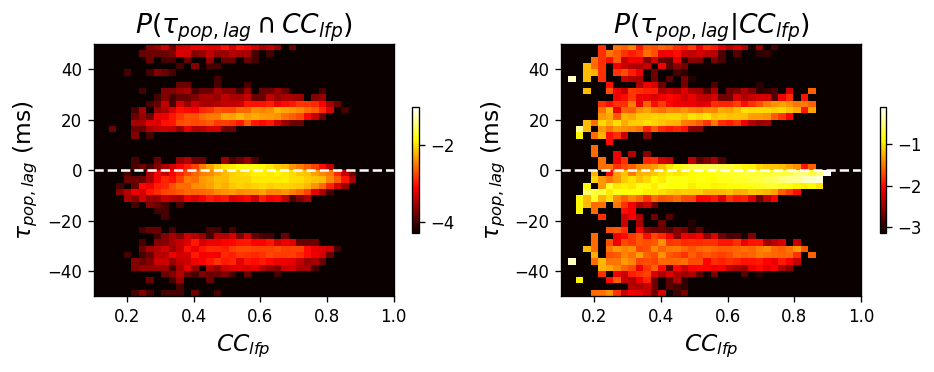

In [379]:
# def draw_prob_map(prob, x, y):
#     hhtools.imshow_xy(prob, x=x, y=y, cmap="hot")
    

def log_prob_map(prob, pth=1e-9):
    tmp_prob = prob.copy()
    pmin = np.min(tmp_prob[tmp_prob > pth])
    tmp_prob[tmp_prob < pth] = pmin
    return np.log10(tmp_prob)


x = get_edge_half(cc_edges)
y = get_edge_half(tlag_pop_edges)
cond = cond_prob(joint)


plt.figure(figsize=(8, 3.2))
plt.subplot(121)
log_joint = log_prob_map(joint)
draw_prob_map(log_joint, x, y*1e3, vmax=-1)
plt.plot([0.1, 1], [0, 0], 'w--')
plt.colorbar(shrink=0.5)
plt.xlabel(r"$CC_{lfp}$", fontsize=14)
plt.ylabel(r"$\tau_{pop, lag}$ (ms)", fontsize=14)
plt.title(r"$P(\tau_{pop, lag} \cap CC_{lfp})$", fontsize=16)

plt.subplot(122)
log_cond = log_prob_map(cond)
draw_prob_map(log_cond, x, y*1e3, vmax=-0.1, vmin=None)
plt.plot([0.1, 1], [0, 0], 'w--')
plt.colorbar(shrink=0.5)
plt.xlabel(r"$CC_{lfp}$", fontsize=14)
plt.ylabel(r"$\tau_{pop, lag}$ (ms)", fontsize=14)
plt.title(r"$P(\tau_{pop, lag} | CC_{lfp})$", fontsize=16)

plt.tight_layout()
plt.show()

## Total samples

In [421]:
from numba import jit

@jit(nopython=True)
def get_bin_id(x, xedges):
    dx = xedges[1] - xedges[0]
    return int((x - xedges[0]) / dx)

np.random.seed(2000)
num_x, num_y = 41, 41

# Global parameters
tmax = 10.5
teq = 0.5
wbin_t = 0.2
srate = 2000

sobj = hhtools.SummaryLoader("./data")

wbin = int(wbin_t * srate)
cc_edges = np.linspace(0.1, 1, num_x)
cc_pop_edges   = np.linspace(0.1, 1, num_y)
tlag_pop_edges = np.linspace(-0.05, 0.05, num_y)

joint_cc = np.zeros([8, num_y-1, num_x-1]) # # of clusters, ., .
joint_tlag = np.zeros([8, num_y-1, num_x-1])

for cid in range(1, 9):
    for ni in trange(200, desc="cid%d"%(cid)):
        detail = sobj.load_detail(cid-1, ni)

        pop_rate, t = get_pop_rate(detail["step_spk"])
        pop_rate = savgol_filter(pop_rate, 11, 1)
        vlfp = detail["vlfp"][1:]

        for n in range(nsample):
            n0 = int((np.random.rand() * (tmax - teq - wbin_t) + teq) * srate)

            cc_v, t = hhsignal.get_correlation(vlfp[0][n0:n0+wbin], vlfp[1][n0:n0+wbin], srate=srate, max_lag=0.05)
            cc_t, t = hhsignal.get_correlation(pop_rate[0][n0:n0+wbin], pop_rate[1][n0:n0+wbin], srate=srate, max_lag=0.05)

            cc_max = np.max(cc_v)
            nmax = np.argmax(cc_v)
            cc_pop_max = cc_t[nmax]
            # cc_pop_max = np.max(cc_t)
            tlag_max = t[np.argmax(cc_t)]

            nx = get_bin_id(cc_max, cc_edges)
            ny_cc = get_bin_id(cc_pop_max, cc_pop_edges)
            ny_t  = get_bin_id(tlag_max, tlag_pop_edges)
            
            if out_range(nx, [0, num_x-1]): continue
            if not out_range(ny_cc, [0, num_y-1]):
                joint_cc[cid-1, ny_cc, nx] += 1
            if not out_range(ny_t,  [0, num_y-1]):
                joint_tlag[cid-1, ny_t, nx] += 1

joint_cc /= np.sum(joint_cc)
joint_tlag  /= np.sum(joint_tlag)


Load cache file


cid8: 100%|███████████████████████████████████████████████████████████████| 200/200 [00:07<00:00, 25.43it/s]


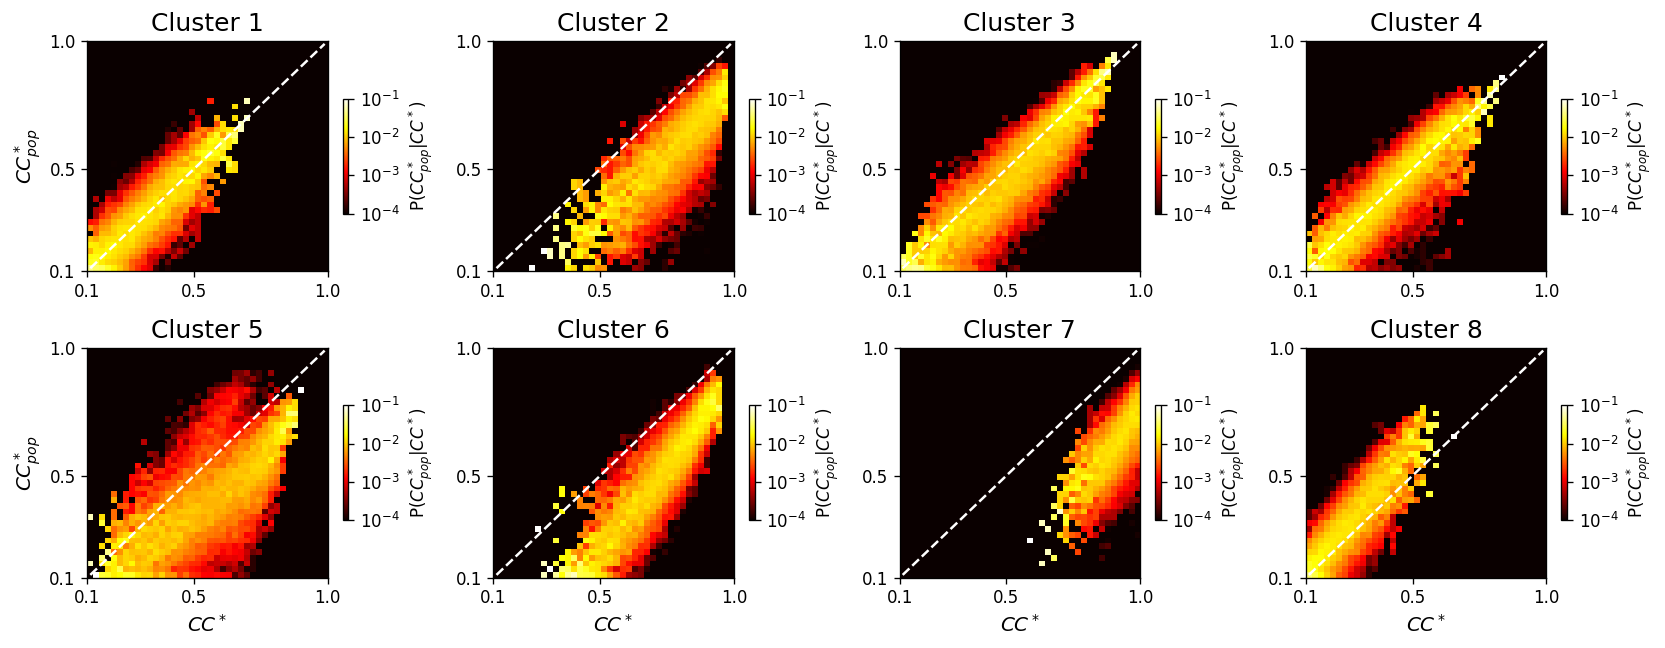

In [435]:
x = get_edge_half(cc_edges)
y = get_edge_half(cc_pop_edges)

plt.figure(figsize=(14, 5.5), dpi=120)
for nc in range(8):
    plt.subplot(2,4,nc+1)
    log_cond = log_prob_map(cond_prob(joint_cc[nc]))
    hhtools.imshow_xy(log_cond, x=x, y=y,
                      cmap="hot",
                      interpolation="none", vmin=-4, vmax=-1)
    
    # plt.yticks([-50, 0, 50])
    plt.xticks([0.1, 0.5, 1])
    plt.yticks([0.1, 0.5, 1])
    plt.plot([x[0], x[-1]], [y[0], y[-1]], 'w--')
    
    cbar = plt.colorbar(shrink=0.5, label=r"P($CC^*_{pop} | CC^*$)")
    ct = [-1, -2, -3, -4]
    cbar.set_ticks(ct)
    cbar.set_ticklabels([r"$10^{%d}$"%(n) for n in ct])
    # print(cbar.get_ticks())
    
    plt.title("Cluster %d"%(nc+1), fontsize=15)
    
    if nc % 4 == 0:
        plt.ylabel(r"$CC^*_{pop}$", fontsize=12)
    
    if nc > 3:
        plt.xlabel(r"$CC^*$", fontsize=12)

        
    # plt.suptitle(r"P($\tau^*_{lag} | CC^*$)", fontsize=15)
    
plt.tight_layout()
plt.show()

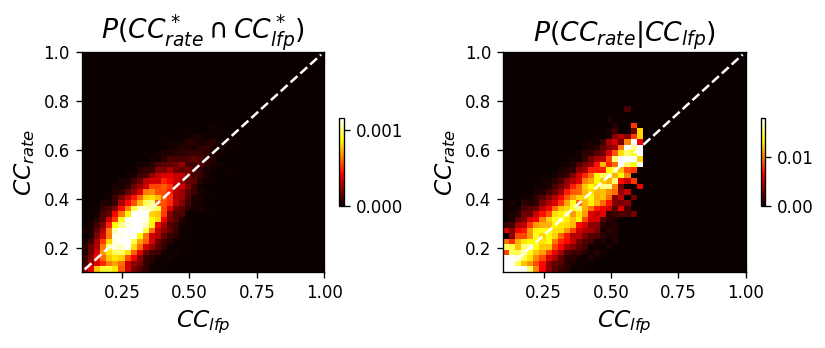

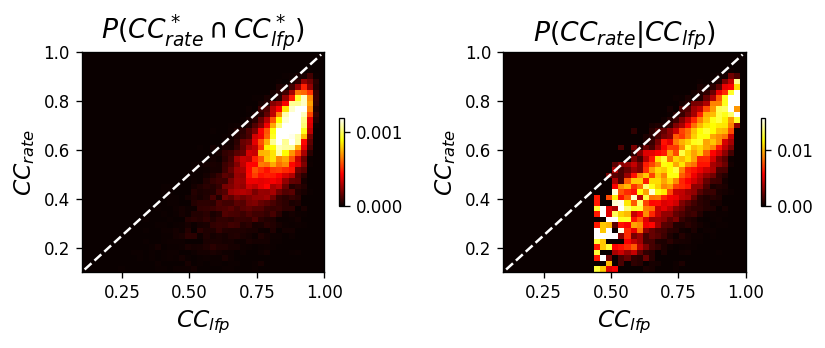

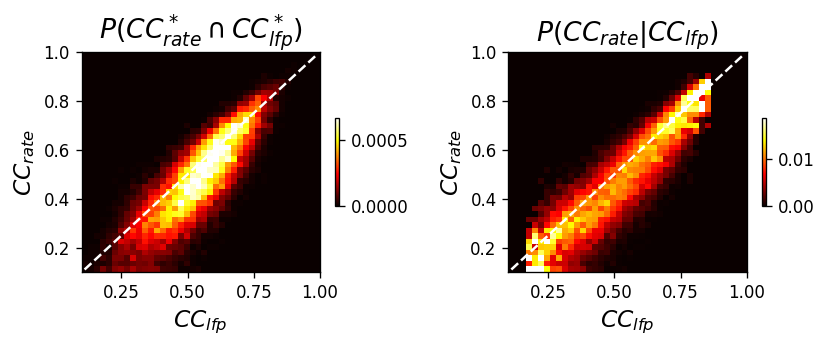

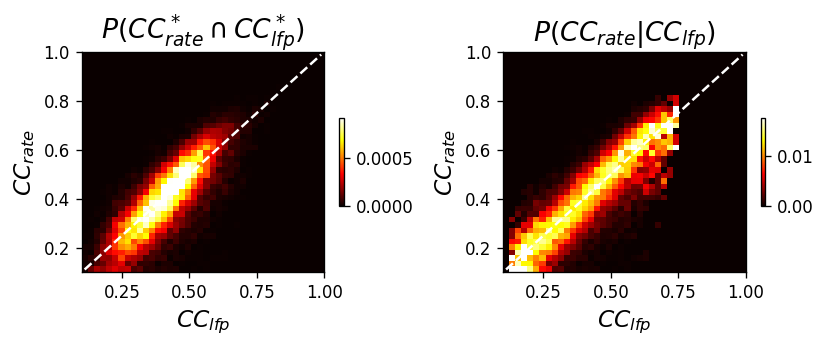

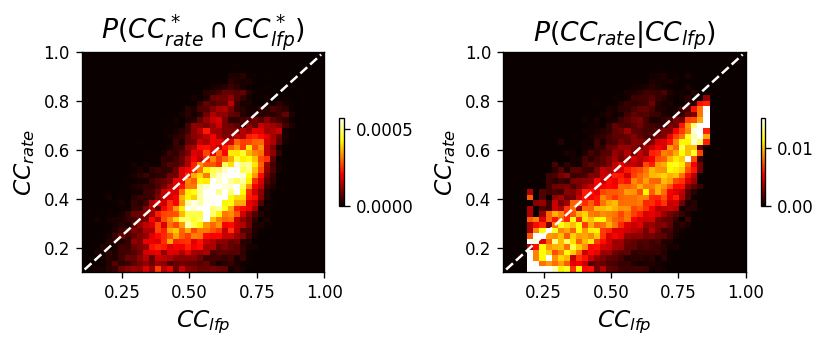

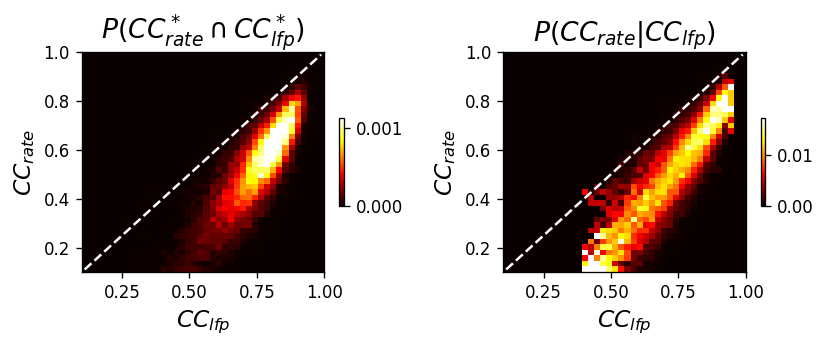

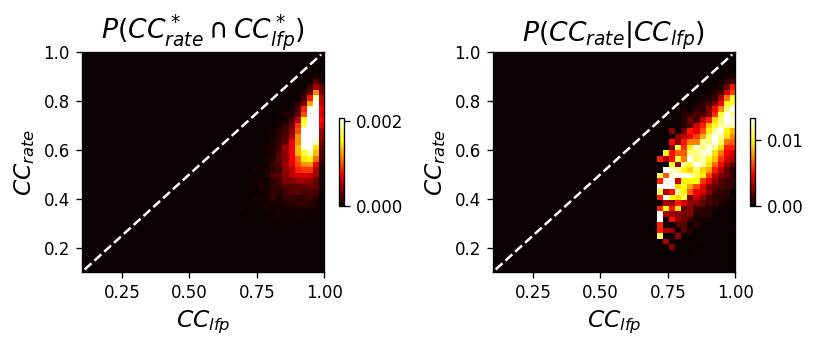

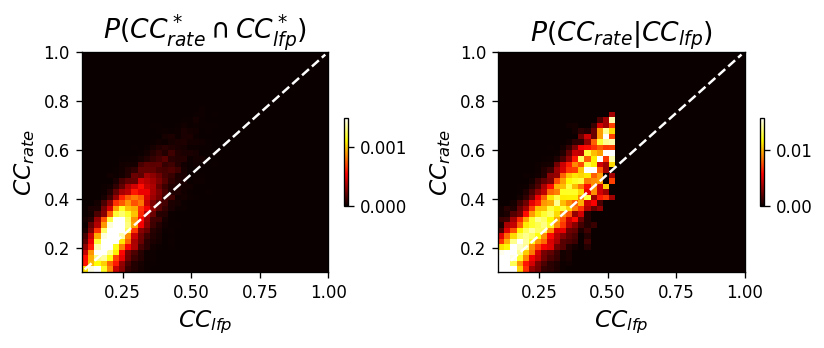

In [422]:
x = get_edge_half(cc_edges)
y = get_edge_half(cc_pop_edges)

for cid in range(1, 9):

    cond = cond_prob(joint_cc[cid-1], pth=1e-3)

    plt.figure(figsize=(7, 3))

    plt.subplot(121)
    draw_prob_map(joint_cc[cid-1], x, y)
    plt.plot([x[0], x[-1]], [y[0], y[-1]], 'w--')
    plt.colorbar(shrink=0.4)
    plt.xlabel(r"$CC_{lfp}$", fontsize=14)
    plt.ylabel(r"$CC_{rate}$", fontsize=14)
    plt.title(r"$P(CC^*_{rate} \cap CC^*_{lfp})$", fontsize=16)

    plt.subplot(122)
    draw_prob_map(cond, x, y)
    plt.plot([x[0], x[-1]], [y[0], y[-1]], 'w--')
    plt.colorbar(shrink=0.4)
    plt.xlabel(r"$CC_{lfp}$", fontsize=14)
    plt.ylabel(r"$CC_{rate}$", fontsize=14)
    plt.title(r"$P(CC_{rate} | CC_{lfp})$", fontsize=16)

    plt.tight_layout()
    plt.show()

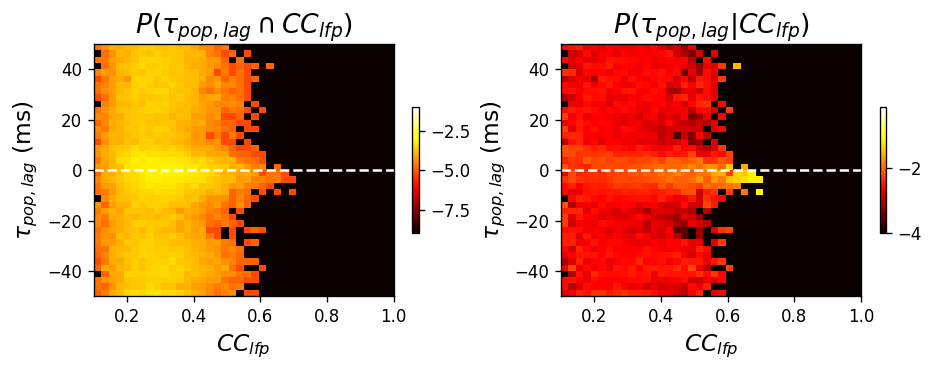

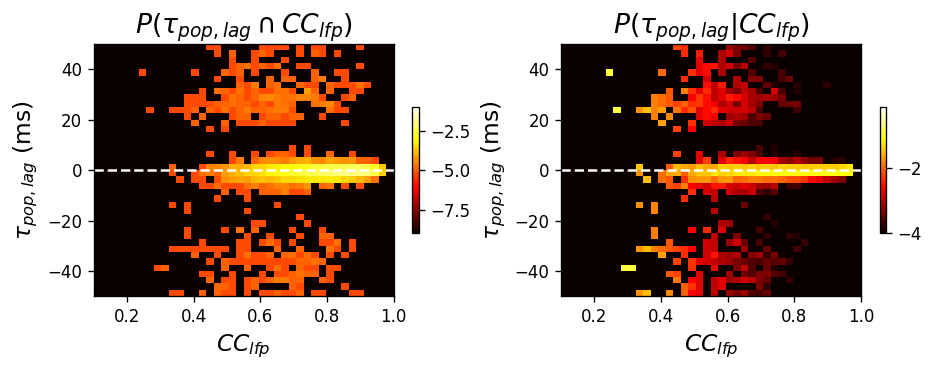

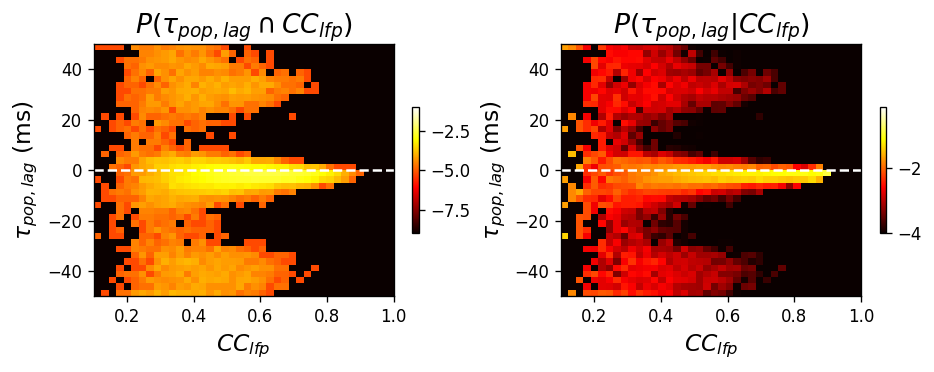

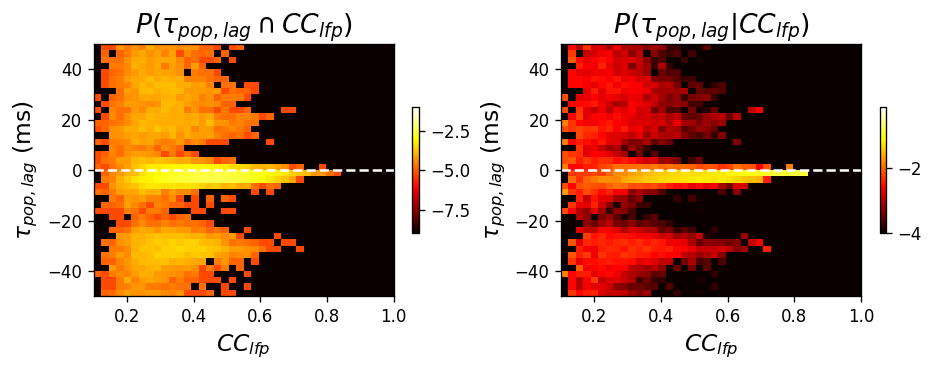

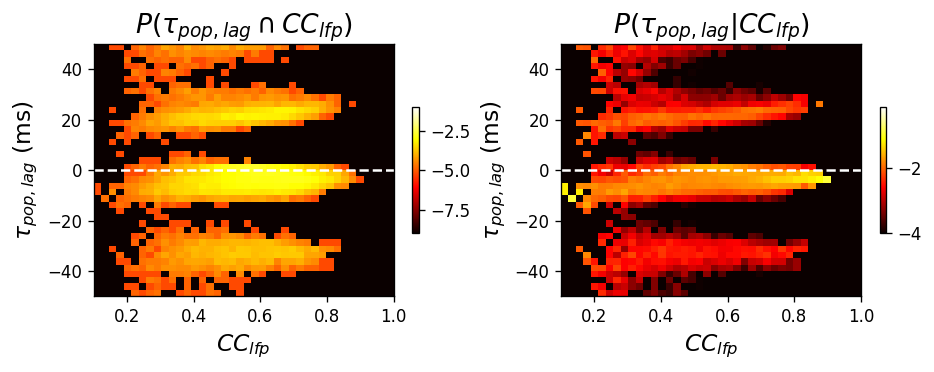

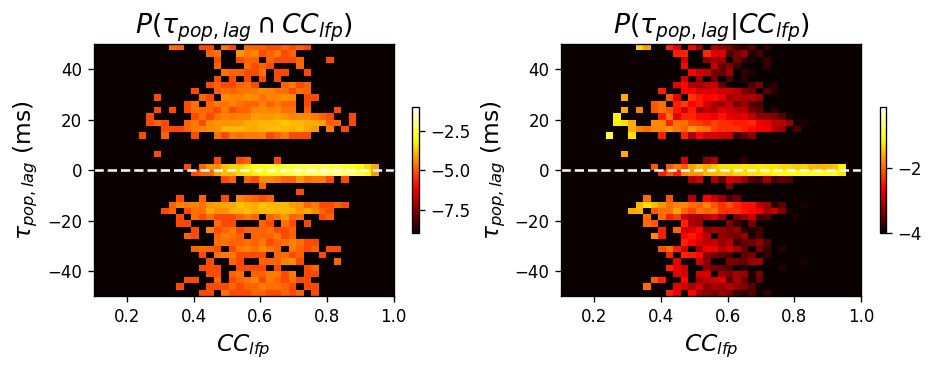

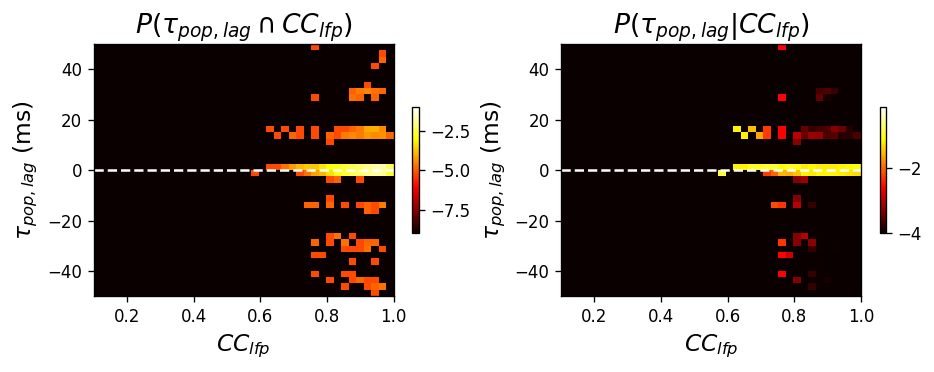

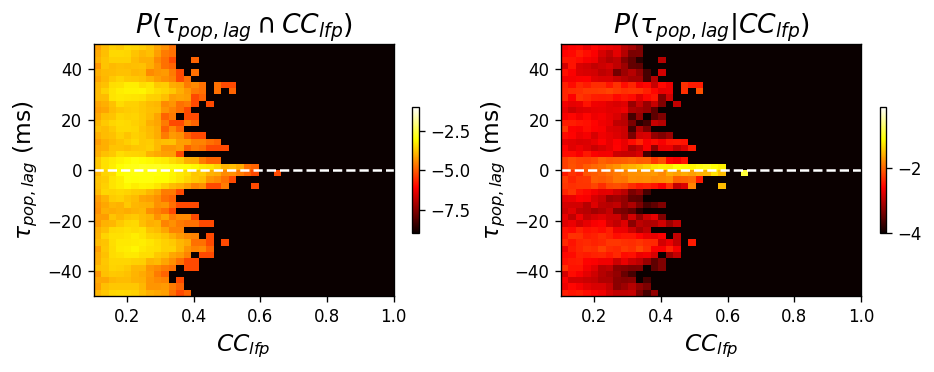

In [423]:
# def draw_prob_map(prob, x, y):
#     hhtools.imshow_xy(prob, x=x, y=y, cmap="hot")
    

def log_prob_map(prob, pth=1e-9):
    tmp_prob = prob.copy()
    pmin = np.min(tmp_prob[tmp_prob > pth])
    tmp_prob[tmp_prob < pth] = pth
    return np.log10(tmp_prob)

for cid in range(1, 9):
    joint = joint_tlag[cid-1]
    
    x = get_edge_half(cc_edges)
    y = get_edge_half(tlag_pop_edges)
    cond = cond_prob(joint)


    plt.figure(figsize=(8, 3.2))
    plt.subplot(121)
    log_joint = log_prob_map(joint)
    draw_prob_map(log_joint, x, y*1e3, vmax=-1)
    plt.plot([0.1, 1], [0, 0], 'w--')
    plt.colorbar(shrink=0.5)
    plt.xlabel(r"$CC_{lfp}$", fontsize=14)
    plt.ylabel(r"$\tau_{pop, lag}$ (ms)", fontsize=14)
    plt.title(r"$P(\tau_{pop, lag} \cap CC_{lfp})$", fontsize=16)

    plt.subplot(122)
    log_cond = log_prob_map(cond)
    draw_prob_map(log_cond, x, y*1e3, vmax=-0.15, vmin=-4)
    plt.plot([0.1, 1], [0, 0], 'w--')
    plt.colorbar(shrink=0.5)
    plt.xlabel(r"$CC_{lfp}$", fontsize=14)
    plt.ylabel(r"$\tau_{pop, lag}$ (ms)", fontsize=14)
    plt.title(r"$P(\tau_{pop, lag} | CC_{lfp})$", fontsize=16)

    plt.tight_layout()
    plt.show()

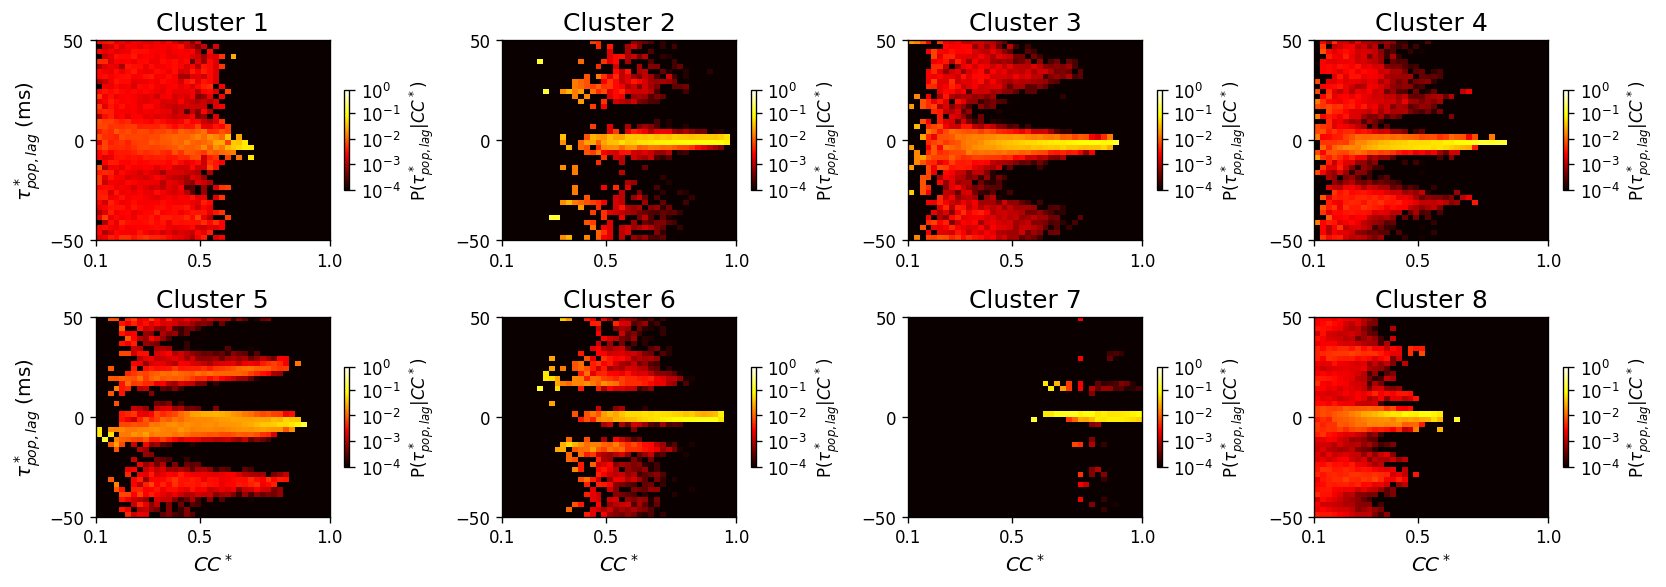

In [424]:
x = get_edge_half(cc_edges)
y = get_edge_half(tlag_pop_edges) * 1e3

plt.figure(figsize=(14, 5), dpi=120)
for nc in range(8):
    plt.subplot(2,4,nc+1)
    log_cond = log_prob_map(cond_prob(joint_tlag[nc]))
    hhtools.imshow_xy(log_cond, x=x, y=y,
                      cmap="hot",
                      interpolation="none", vmin=-4, vmax=-0.1)
    
    plt.yticks([-50, 0, 50])
    plt.xticks([0.1, 0.5, 1])
    
    cbar = plt.colorbar(shrink=0.5, label=r"P($\tau^*_{pop, lag} | CC^*$)")
    ct = [-0.1, -1, -2, -3, -4]
    cbar.set_ticks(ct)
    cbar.set_ticklabels([r"$10^{%d}$"%(n) for n in ct])
    # print(cbar.get_ticks())
    
    plt.title("Cluster %d"%(nc+1), fontsize=15)
    
    if nc % 4 == 0:
        plt.ylabel(r"$\tau^*_{pop, lag}$ (ms)", fontsize=12)
    
    if nc > 3:
        plt.xlabel(r"$CC^*$", fontsize=12)

        
    # plt.suptitle(r"P($\tau^*_{lag} | CC^*$)", fontsize=15)
    
plt.tight_layout()
plt.show()

In [284]:
from scipy.signal import correlate

def corr(x, y, srate, ny=None, max_lag=None):
    # move y to x
    
    if max_lag is None:
        max_lag = len(y)/srate
    max_pad = max_lag * srate
    
    x_sub = x[int(ny-max_pad):int(ny+len(y)+max_pad)]
    std = [np.std(x_sub), np.std(y)]
    
    if (std[0] == 0) or (std[1] == 0):  
        return np.zeros(2*max_pad+1)
    
    xn = (x_sub - np.average(x_sub)) / std[0]
    yn = (y - np.average(y)) / std[1]
    
    cc = correlate(xn, yn, mode="valid")
    
    tlag = np.arange(-max_lag, max_lag+1/srate/10, 1/srate)
    cc = cc / len(y)
    
    return cc, tlag
    

In [334]:
cc, tlag = hhsignal.get_correlation(x, y, srate, max_lag=0.05)
cc_y, tlag = corr(pop_rate[0], y, srate, ny=n0, max_lag=0.05)
cc_x, tlag = corr(pop_rate[1], x, srate, ny=n0, max_lag=0.05)

# len(tlag), len(cc)

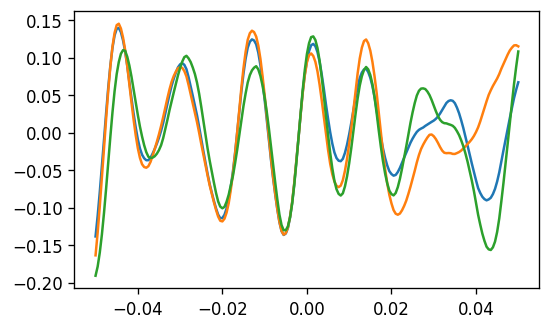

In [339]:
plt.figure(figsize=(5, 3))
plt.plot(tlag, cc)
plt.plot(tlag, cc_y)
plt.plot(tlag, cc_x[::-1])
plt.show()